# Assignment 4 — Non-Linear Models (Part 2)

This notebook includes solutions for Conceptual Question 3, Applied Question 8 (Auto dataset),
and two non-linear regression models for the Abalone Kaggle competition dataset.

## Conceptual Question 3 (ISLR p. 326)
We consider the fitted curve defined by:
$$\hat{Y}(X) = 1 + X - 2(X - 1)^2 I(X \ge 1).$$
For $X < 1$, the curve is linear with slope 1. For $X \ge 1$, the curve becomes a
downward-opening parabola. The plot below visualizes this piecewise function.

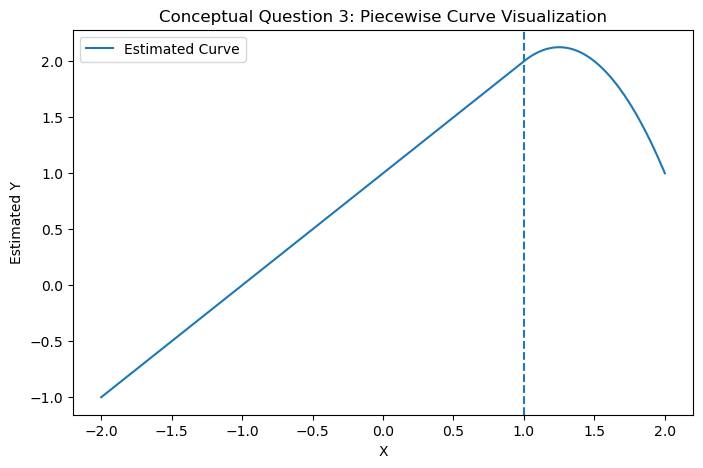

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-2, 2, 400)
y = []
for val in x:
    if val < 1:
        y.append(1 + val)
    else:
        y.append(1 + val - 2*(val - 1)**2)
y = np.array(y)

plt.figure(figsize=(8,5))
plt.plot(x, y, label='Estimated Curve')
plt.axvline(1, linestyle='--')
plt.title('Conceptual Question 3: Piecewise Curve Visualization')
plt.xlabel('X')
plt.ylabel('Estimated Y')
plt.legend()
plt.show()

## Applied Question 8 (ISLR p. 327) — Auto Data
We assess evidence for non-linear relationships in the Auto dataset by fitting
linear, polynomial, and spline models predicting MPG from horsepower.

In [2]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from patsy import dmatrix

# Load Auto dataset (ensure Auto.csv is in the working directory)
auto = pd.read_csv('Auto.csv')
auto = auto.replace('?', np.nan)
auto['horsepower'] = pd.to_numeric(auto['horsepower'])
auto = auto.dropna(subset=['mpg', 'horsepower'])

X_auto = auto[['horsepower']].values
y_auto = auto['mpg'].values

In [3]:
# Linear model
lin_auto = LinearRegression().fit(X_auto, y_auto)

# Polynomial model (degree 3)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_auto_poly = poly.fit_transform(X_auto)
poly_auto = LinearRegression().fit(X_auto_poly, y_auto)

# Natural spline model with df=4
spline_basis_auto = dmatrix('bs(horsepower, df=4, include_intercept=False)',
                            {'horsepower': auto['horsepower']}, return_type='dataframe')
spline_auto = sm.OLS(y_auto, spline_basis_auto).fit()

In [4]:
# Performance metrics for Auto models
y_auto_lin = lin_auto.predict(X_auto)
y_auto_poly = poly_auto.predict(X_auto_poly)
y_auto_spline = spline_auto.predict(spline_basis_auto)

metrics_auto = pd.DataFrame({
    'Model': ['Linear', 'Polynomial (3rd degree)', 'Natural Spline (df=4)'],
    'RMSE': [np.sqrt(mean_squared_error(y_auto, y_auto_lin)),
             np.sqrt(mean_squared_error(y_auto, y_auto_poly)),
             np.sqrt(mean_squared_error(y_auto, y_auto_spline))],
    'R2': [r2_score(y_auto, y_auto_lin),
           r2_score(y_auto, y_auto_poly),
           r2_score(y_auto, y_auto_spline)]
})
metrics_auto

,Model,RMSE,R2
0,Linear,4.893226,0.605948
1,Polynomial (3rd degree),4.352584,0.688214
2,Natural Spline (df=4),4.308423,0.694508


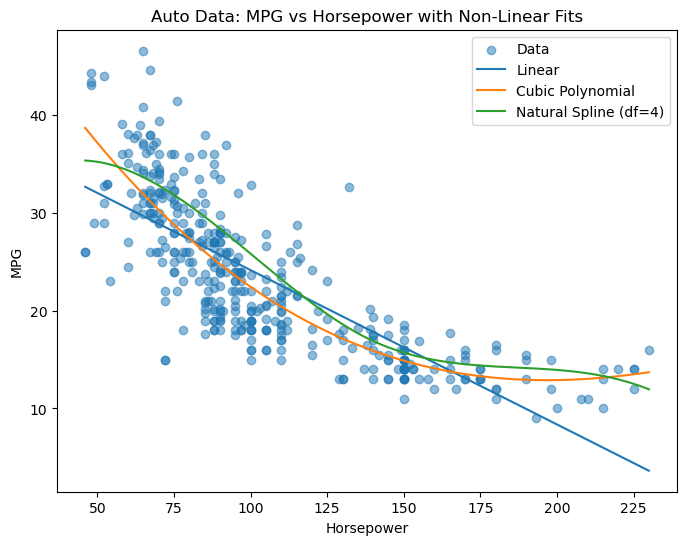

In [5]:
# Visual comparison of Auto models
hp_grid = np.linspace(X_auto.min(), X_auto.max(), 200).reshape(-1, 1)
y_lin_hat = lin_auto.predict(hp_grid)
y_poly_hat = poly_auto.predict(poly.transform(hp_grid))
spline_grid = dmatrix('bs(horsepower, df=4, include_intercept=False)',
                      {'horsepower': hp_grid.ravel()}, return_type='dataframe')
y_spline_hat = spline_auto.predict(spline_grid)

plt.figure(figsize=(8,6))
plt.scatter(auto['horsepower'], auto['mpg'], alpha=0.5, label='Data')
plt.plot(hp_grid, y_lin_hat, label='Linear')
plt.plot(hp_grid, y_poly_hat, label='Cubic Polynomial')
plt.plot(hp_grid, y_spline_hat, label='Natural Spline (df=4)')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Auto Data: MPG vs Horsepower with Non-Linear Fits')
plt.legend()
plt.show()

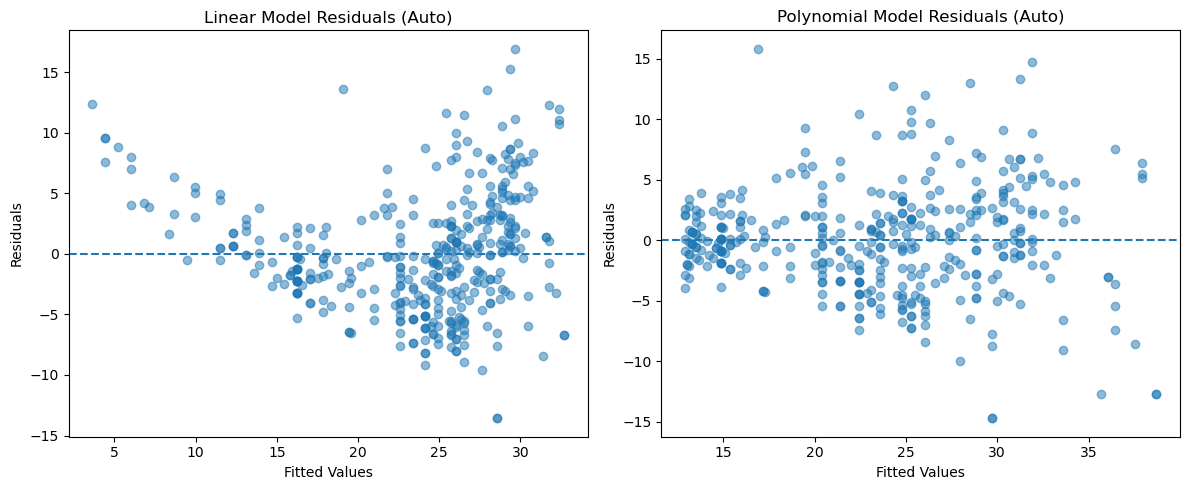

In [6]:
# Residual diagnostics for Auto models
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_auto_lin, y_auto - y_auto_lin, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.title('Linear Model Residuals (Auto)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.subplot(1,2,2)
plt.scatter(y_auto_poly, y_auto - y_auto_poly, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.title('Polynomial Model Residuals (Auto)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

## Abalone Kaggle Models — Polynomial and Spline Regression
In this section, we build two non-linear models for the Abalone dataset from Kaggle:
a polynomial regression model using all numeric predictors and a spline-based model
using a spline transformation of Length.

In [7]:
# Load Abalone Kaggle data (ensure these files are in the working directory)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [8]:
# Preprocess Abalone data
features = ['Sex', 'Length', 'Diameter', 'Height',
            'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
target = 'Rings'

# One-hot encode Sex
X_train_base = pd.get_dummies(train[features], columns=['Sex'], drop_first=True)
X_test_base = pd.get_dummies(test[features], columns=['Sex'], drop_first=True)

# Align columns between train and test
X_test_base = X_test_base.reindex(columns=X_train_base.columns, fill_value=0)

y_train = train[target].values

### Model 1: Polynomial Regression (Abalone)
We fit a degree-2 polynomial regression model using all numeric predictors
and one-hot encoded Sex.

In [9]:
poly_abalone = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_abalone.fit_transform(X_train_base)
X_test_poly = poly_abalone.transform(X_test_base)

lin_poly_abalone = LinearRegression().fit(X_train_poly, y_train)
y_train_pred_poly = lin_poly_abalone.predict(X_train_poly)

rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
r2_poly = r2_score(y_train, y_train_pred_poly)
rmse_poly, r2_poly

(np.float64(1.9097233684355268), 0.6384866769404045)

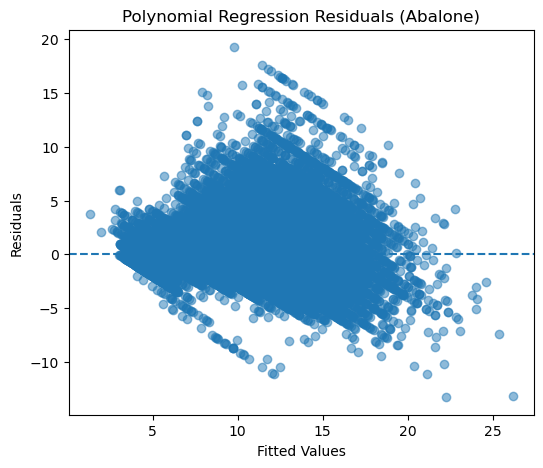

In [10]:
# Residual diagnostics for polynomial model (Abalone)
plt.figure(figsize=(6,5))
plt.scatter(y_train_pred_poly, y_train - y_train_pred_poly, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Polynomial Regression Residuals (Abalone)')
plt.show()

In [11]:
# Create Kaggle submission for polynomial model
abalone_poly_pred = lin_poly_abalone.predict(X_test_poly)
submission_poly = sample_sub.copy()
submission_poly['Rings'] = abalone_poly_pred
submission_poly.to_csv('abalone_polynomial_submission.csv', index=False)
submission_poly.head()

,id,Rings
0,90615,9.262674
1,90616,9.733078
2,90617,10.468224
3,90618,10.132301
4,90619,7.657147


### Model 2: Spline-Based Regression (Abalone)
We fit a spline-based model using a natural spline transformation of Length
to capture non-linear effects of shell length on Rings.

In [12]:
# Build spline basis for Length in Abalone data
spline_basis_len_train = dmatrix('bs(Length, df=4, include_intercept=False)',
                                 data=train, return_type='dataframe')
spline_len_model = sm.OLS(y_train, spline_basis_len_train).fit()
y_train_pred_spline = spline_len_model.predict(spline_basis_len_train)

rmse_spline = np.sqrt(mean_squared_error(y_train, y_train_pred_spline))
r2_spline = r2_score(y_train, y_train_pred_spline)
rmse_spline, r2_spline

(np.float64(2.4734878132162024), 0.39353892370116994)

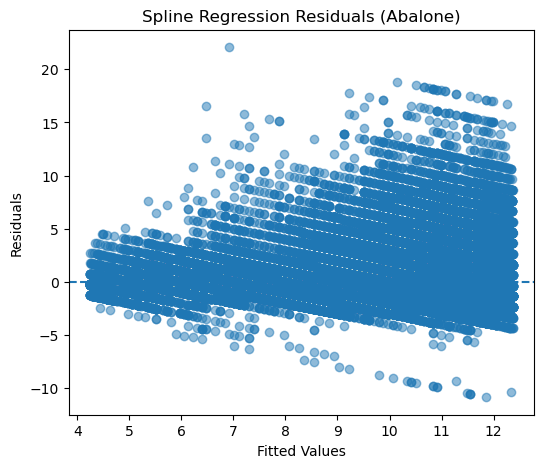

In [13]:
# Residual diagnostics for spline model (Abalone)
plt.figure(figsize=(6,5))
plt.scatter(y_train_pred_spline, y_train - y_train_pred_spline, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Spline Regression Residuals (Abalone)')
plt.show()

In [14]:
# Create Kaggle submission for spline model (based on Length only)
spline_basis_len_test = dmatrix('bs(Length, df=4, include_intercept=False)',
                                data=test, return_type='dataframe')
abalone_spline_pred = spline_len_model.predict(spline_basis_len_test)

submission_spline = sample_sub.copy()
submission_spline['Rings'] = abalone_spline_pred
submission_spline.to_csv('abalone_spline_submission.csv', index=False)
submission_spline.head()

,id,Rings
0,90615,11.898075
1,90616,11.027911
2,90617,10.700232
3,90618,10.866860
4,90619,7.948907
